# Intersection over Unity score

In [25]:
import csv
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import numpy as np
import seaborn as sns
import datetime as datetime
from netCDF4 import num2date, date2num
from pyclouds import zooniverse as zn

from PIL import Image
import matplotlib.patches as patches
import matplotlib.image as mpimage

import numba as nb
from collections import defaultdict
import itertools

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [9]:
classification_data = zn.parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']);
prac_dataset = classification_data[np.logical_and(classification_data.workflow_id == 8072,
                                                  classification_data.workflow_version == 24.13) ]; prac_dataset.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
1,128490303,not-logged-in-fc5633eea5ed2784d18f,NaN,fc5633eea5ed2784d18f,8072,Practice,24.13,2018-10-24 18:57:11 UTC,NaN,NaN,"{'source': 'api', 'session': '87cebe5a5f8df494...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977308': {'retired': None, 'fn': '/project...",26977308
2,128623366,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:49:06 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976669': {'retired': None, 'fn': '/project...",26976669
3,128623455,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:49:36 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976422': {'retired': None, 'fn': '/project...",26976422
4,128623533,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:50:08 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977225': {'retired': None, 'fn': '/project...",26977225
5,128623611,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:50:39 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977129': {'retired': None, 'fn': '/project...",26977129


In [10]:
unique_users = list(prac_dataset['user_name'].unique())

In [11]:
# Restrict comparision only to people who did more than x classifications
unique_users = []
for u,user in prac_dataset.groupby('user_name'):
    if len(user) > 20:
        unique_users.append(u)

In [12]:
image_width =2100
image_height=1400
annos_prac = defaultdict(list)
for i, r in prac_dataset.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos_prac[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos_prac[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [13]:
subjects_prac = list(annos_prac.keys()); len(subjects_prac)

65

In [14]:
annos_prac.keys()

dict_keys([26977308, 26976669, 26976422, 26977225, 26977129, 26976823, 26976672, 26977174, 26976707, 26976578, 26976643, 26976481, 27139777, 27140534, 27140554, 27140608, 27139862, 27140428, 27139658, 27140338, 27140007, 27140443, 27140160, 27140411, 27139807, 27139637, 27139670, 27139724, 27140553, 27140272, 27140248, 27140136, 27140273, 27140760, 27139855, 27140640, 27140686, 27139989, 27139657, 27140139, 27140219, 27140799, 27140298, 27140789, 27139915, 27139921, 27140510, 27140739, 27140444, 27140829, 27140720, 27140749, 27140183, 27139914, 27140649, 27139823, 27140434, 27140513, 27140456, 27139668, 27140002, 27139902, 27140299, 27140038, 27140128])

In [15]:
def get_comp_data(subject_id, user1, user2, annos):
    subj_annos = annos[subject_id]
    users = list(set([a[0] for a in subj_annos]))
    if user1 in users and user2 in users:
        annos1 = [a[1:] for a in subj_annos if a[0] == user1]
        annos2 = [a[1:] for a in subj_annos if a[0] == user2]
        if annos1[0][1] is None and annos2[0][1] is None:
            iou = 1.
        elif annos1[0][1] is None:
            iou = 0.
        elif annos2[0][1] is None:
            iou = 0.
        else:
            iou = iou_multi_class(annos1, annos2)
        return iou
    else:
        return None

In [16]:
def iou_multi_class(annos1, annos2):
    """For two users"""
    classes = ['Sugar', 'Flower', 'Fish', 'Gravel']
    i_tot = 0; u_tot = 0
    for c in classes:
        ac1 = [a[0] for a in annos1 if a[1] == c]
        ac2 = [a[0] for a in annos2 if a[1] == c]
        if len(ac1) == 0 and len(ac2) == 0:   # None of the users has this class
            i = 0; u = 0
        elif len(ac1) == 0 or len(ac2) == 0:
            i = 0
            u = compute_area_sum(ac1 + ac2)
        else:
            i, u = iou_one_class(ac1, ac2)
        i_tot += i; u_tot += u
    return i_tot / u_tot

In [17]:
def iou_one_class(annos1, annos2):
    """annos1 and annos2 are lists with the coordinates of each annotation"""
    import itertools
    # All permutations
    i = 0
    for a1 in annos1:
        for a2 in annos2:
            i += compute_intersect(a1, a2)
    # Need to compute the overlap between the boxes of 1 and 2
    i1 = 0; i2 = 0
    for b1, b2 in itertools.combinations(annos1, 2):
        i1 += compute_intersect(b1, b2)
    for b1, b2 in itertools.combinations(annos2, 2):
        i2 += compute_intersect(b1, b2)
    u = compute_area_sum(annos1 + annos2) - i# - i1 -i2
    
    iou = i/u  #(i - i1 - i2) / u
    return i, u

In [18]:
def compute_intersect(a1, a2):
    """https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/"""
    x1a, y1a, x2a, y2a = wh2xy(*a1)
    x1b, y1b, x2b, y2b = wh2xy(*a2)
    xA = max(x1a, x1b)
    yA = max(y1a, y1b)
    xB = min(x2a, x2b)
    yB = min(y2a, y2b)
    i = max(0, xB - xA) * max(0, yB - yA) # max(0, xB - xA + 1) * max(0, yB - yA + 1)
    return i

In [19]:
def compute_area_sum(annos):
    areas = [a[2] * a[3] for a in annos]
    return np.sum(areas)

In [20]:
def wh2xy(x, y, w, h):
    return x, y, x+w, y+h

In [21]:
agreement  = defaultdict(list)
for s in subjects_prac:
    for u in unique_users:
        agreement[u].append(get_comp_data(s, 'sbony', u, annos_prac))

In [22]:
df = pd.DataFrame(data = {'agreement': [np.mean([a for a in agreement[u] if a is not None]) for u in unique_users]}, index=unique_users)

In [23]:
df.sort_values('agreement', axis=0, ascending=False, inplace=True)

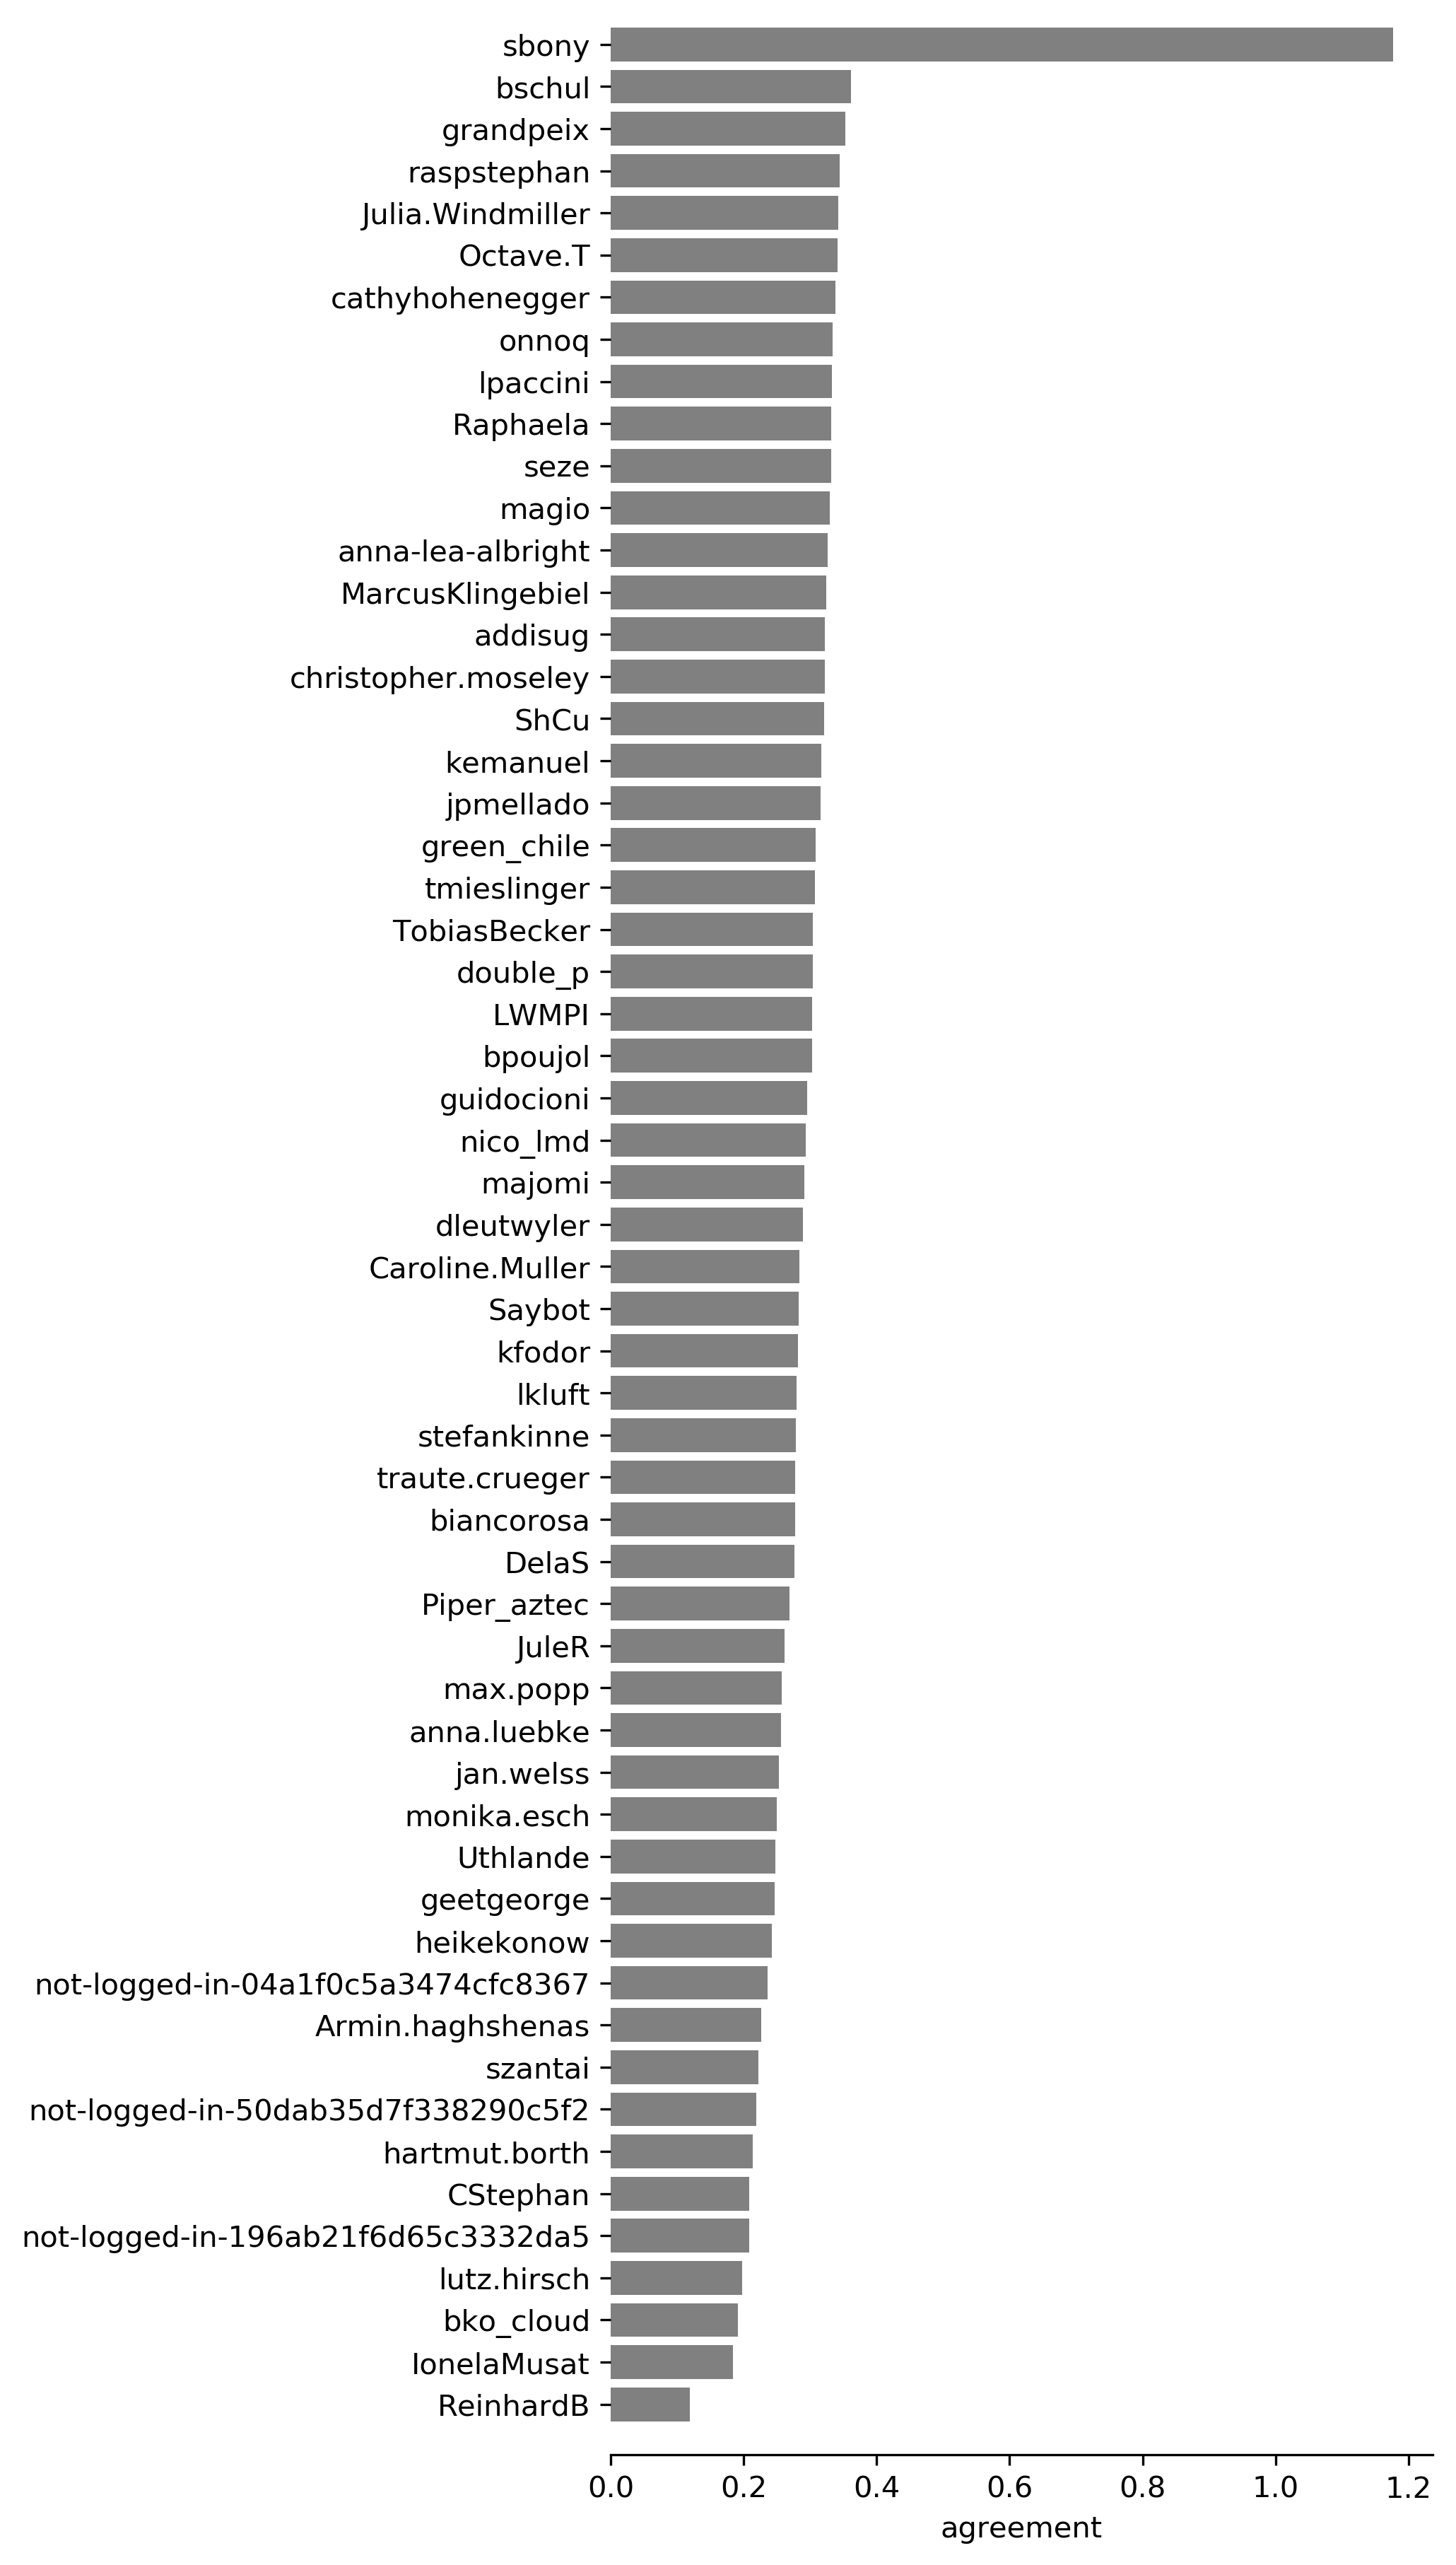

In [24]:
fig = plt.figure(figsize=(5, 15))
sns.barplot(x=df['agreement'], y=df.index,color="grey")
sns.despine(offset=10,left=True)
fig.set_dpi(300)